In [1]:
import sys
sys.path.append("./reddit/")

In [19]:
import pickle

import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import rcParams
import numpy as np
import json
from tqdm.auto import tqdm, trange
from features import merge_entries, prepare_entry, get_nltk_pos_tag_based_ml_chunker
import features
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
PAN_DATA_DIR = 'data/pan/'
PAN_GROUND_TRUTH_PATH = PAN_DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'

In [127]:
FIGURES_PATH = 'figures/'
TEXT_WIDTH = 7.0 # Text with on a column
HALF_COL_WIDTH = (TEXT_WIDTH - 0.5)/2
HEIGHT = 2.5

In [5]:

style.use('seaborn-whitegrid')

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = [ 'Times New Roman', 'Times', 'DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Palatino',
 'Charter',
 'serif']
rcParams['font.size']=9 

Single-Doc AV Approach
====

Dataset Stats
===

PAN
---

In [6]:
with open('temp_data/pan/dataset_partition.p', 'rb') as f:
    (train_ids, test_ids, train_authors, test_authors) = pickle.load(f)

In [11]:
print('Num Pairs:', (len(train_ids) + len(test_ids)))
print('Num Docs:', 2 * (len(train_ids) + len(test_ids)))

Num Pairs: 275486
Num Docs: 550972


In [34]:
ground_truth = {}
with open(PAN_GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']

In [40]:
print('Fraction of SA pairs:', np.array(list(ground_truth.values())).mean())

Fraction of SA pairs: 0.5361397675380963


In [ ]:
data_fraction = 0.01
token_lengths = []
char_lengths = []
with open('./temp_data/pan/preprocessed_train.jsonl', 'r') as f:
    for l in tqdm(f):
        if np.random.rand() < data_fraction:
            d = json.loads(l)
            token_lengths.extend([len(c['tokens']) for c in d['pair'][0]])
            char_lengths.extend([len(c['preprocessed']) for c in d['pair'][0]])

In [65]:
print('Tokens per doc:', np.mean(token_lengths), np.std(token_lengths))
print('Chars per doc:', np.mean(char_lengths), np.std(char_lengths))

Tokens per doc: 125.25075228171396 17.310732291179278
Chars per doc: 539.3869836611873 61.89096369113025


Reddit
---

In [12]:
with open('temp_data/reddit/preprocessed/metadata.p', 'rb') as f:
    (train_files, test_files, min_count, author_mapping) = pickle.load(f)

In [90]:
with open('./temp_data/reddit/unchunked/experiment_data.p', 'rb') as f:
    (
        author_to_doc_idx, 
        author_to_doc_idx_test, 
        author_subreddit, 
        author_subreddit_test, 
        x_shape, 
        x_shape_test,
        X_idxs_train,
        Y_train,
        X_idxs_test,
        Y_test
    ) = pickle.load(f)

In [91]:
author_mapping = defaultdict(set)
author_to_root = {}
for y in author_subreddit.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping[u].add(y)
    author_to_root[y] = u
    
author_mapping_test = defaultdict(set)
author_to_root_test = {}
for y in author_subreddit_test.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping_test[u].add(y)
    author_to_root_test[y] = u

In [94]:
print('Num users:', len(author_mapping) + len(author_mapping_test))

Num users: 46465


In [95]:
print('Number of Reddit user pairs:', x_shape[0] + x_shape_test[0])

Number of Reddit user pairs: 126256


In [6]:
preprocessed_path = './temp_data/reddit/preprocessed/train.jsonl'
token_lengths = []
char_lengths = []
comments_per_sr = []
tokens_per_comment = []
chars_per_comment = []

with open(preprocessed_path, 'r') as f:
    for l in tqdm(f):
        d = json.loads(l)
        doc = merge_entries(d['data'])
        token_lengths.append(len(doc['tokens']))
        char_lengths.append(len(doc['preprocessed']))
        
        comments_per_sr.append(len(d['data']))
        tokens_per_comment.extend([len(c['tokens']) for c in d['data']])
        chars_per_comment.extend([len(c['preprocessed']) for c in d['data']])
        

In [7]:
print('Tokens per doc:', np.mean(token_lengths), np.std(token_lengths))
print('Chars per doc:', np.mean(char_lengths), np.std(char_lengths))

Tokens per doc: 3457.3605978750224 6155.246051835943
Chars per doc: 16734.673930007804 32164.098184333987


In [8]:
print('Comments Per Subreddit (Mean)', np.mean(comments_per_sr))
print('Comments Per Subreddit (Std)', np.std(comments_per_sr))

print('Tokens Per Comment (Mean)', np.mean(tokens_per_comment))
print('Tokens Per Comment (Std)', np.std(tokens_per_comment))

print('Chars Per Comment(Mean)', np.mean(chars_per_comment))
print('Chars Per Comment (Std)', np.std(chars_per_comment))

Comments Per Subreddit (Mean) 110.4095443904196
Comments Per Subreddit (Std) 130.72500187247738
Tokens Per Comment (Mean) 31.313964901887804
Tokens Per Comment (Std) 57.609138747208206
Chars Per Comment(Mean) 150.57814500917354
Chars Per Comment (Std) 282.95570701455176


Example
===

In [50]:
text = 'Noel smiled, going off in his own little world.'
e = prepare_entry(text, mode='accurate', tokenizer='casual')

In [53]:
tagger_output = features.perceptron_tagger.tag(e['tokens'])
parse_tree = get_nltk_pos_tag_based_ml_chunker().parse(tagger_output)

In [54]:
parse_tree.pprint()

(S
  (NP Noel/NNP)
  (VP smiled/VBD)
  ,/,
  (VP going/VBG)
  off/RP
  (PP in/IN)
  (NP his/PRP$ own/JJ little/JJ world/NN)
  ./.)


In [55]:
tagger_output

[('Noel', 'NNP'),
 ('smiled', 'VBD'),
 (',', ','),
 ('going', 'VBG'),
 ('off', 'RP'),
 ('in', 'IN'),
 ('his', 'PRP$'),
 ('own', 'JJ'),
 ('little', 'JJ'),
 ('world', 'NN'),
 ('.', '.')]

In [58]:
e['pos_tag_chunk_subtrees']

['NP[NNP]', 'VP[VBD]', 'VP[VBG]', 'PP[IN]', 'NP[PRP$ JJ JJ NN]']

In [57]:
e['pos_tag_chunks']

['NP', 'VP', ',', 'VP', 'RP', 'PP', 'NP', '.']

Classifier Performance
====

In [ ]:
with open('temp_data/reddit/unchunked/training_meta_data.p', 'rb') as f:
    (author_to_doc_idx, author_to_doc_idx_test, author_subreddit, author_subreddit_test, x_shape, x_shape_test) = pickle.load(f)

In [37]:
with open('temp_data/pan/experiment_data.p', 'rb') as f:
    d = pickle.load(f)
    pan_aucs = d[0]
    
with open('temp_data/reddit/unchunked/model.p', 'rb') as f:
    d = pickle.load(f)
    reddit_aucs = d[-1]

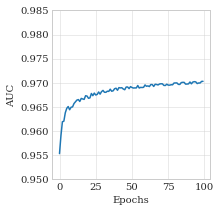

Final AUC: 0.97


In [42]:


fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))
plt_x = list(range(len(pan_aucs)))
plt_y = pan_aucs
plt.plot(plt_x, plt_y, '-')

plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.ylim(0.95, 0.985)
plt.show()

fig.savefig(FIGURES_PATH + 'plt_pan_full_epoch_vs_auc.pdf', bbox_inches='tight')
print('Final AUC:', round(pan_aucs[-1], 3))

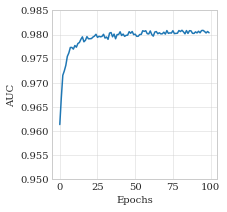

Final AUC: 0.98


In [43]:


fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))
plt_x = list(range(len(reddit_aucs)))
plt_y = reddit_aucs
plt.plot(plt_x, plt_y, '-')

plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.ylim(0.95, 0.985)
plt.show()

fig.savefig(FIGURES_PATH + 'plt_reddit_full_epoch_vs_auc.pdf', bbox_inches='tight')
print('Final AUC:', round(reddit_aucs[-1], 3))

Varying Doc lengths
===

In [118]:
from pan.varying_doc_sizes import SIZES as PAN_SIZES
from reddit.varying_doc_sizes import SIZES as REDDIT_SIZES
from sklearn.metrics import roc_curve, auc

In [119]:
pan_aucs = []
for size in PAN_SIZES:
    with open('./temp_data/pan/doc_size_experiments/size_' + str(size) + '/experiment_data.p', 'rb') as f:
        data = pickle.load(f)
        final_auc = data[0][-1]
        pan_aucs.append(final_auc)

In [74]:
PAN_SIZES

[1, 2, 5, 10, 20, 30, 40]

In [69]:
pan_aucs

[0.7146778157263471,
 0.7851159795255009,
 0.8728131583510979,
 0.922383527055845,
 0.954798917769495,
 0.966898441778403,
 0.9723291154825093]

In [120]:
reddit_aucs = []
for size in REDDIT_SIZES:
    with open('./temp_data/reddit_old/doc_size_experiments/size_' + str(size) + '/model.p', 'rb') as f:
        data = pickle.load(f)
        probs = data[5]
        Y_test = data[6]
        fpr, tpr, thresh = roc_curve(Y_test, probs)
        roc_auc = auc(fpr, tpr)
        reddit_aucs.append(roc_auc)

In [71]:
REDDIT_SIZES

[5, 10, 15, 20, 30, 40, 50, 60, 70, 80]

In [73]:
reddit_aucs

[0.8015404628899654,
 0.8765790495720556,
 0.898272444688294,
 0.9180072807804424,
 0.9431727231899917,
 0.9547066583156244,
 0.9648174617116598,
 0.9683909722125951,
 0.9733653062210245,
 0.9735743403048718]

In [141]:
rcParams['font.size']=11

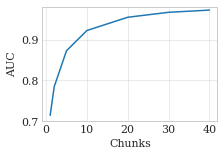

In [142]:


fig = plt.figure(figsize=(HALF_COL_WIDTH, 2.3))
plt_x = PAN_SIZES
plt_y = pan_aucs
plt.plot(plt_x, plt_y, '-')

plt.xlabel('Chunks')
plt.ylabel('AUC')
plt.grid(True, alpha=0.5)
plt.ylim(0.7, 0.98)
plt.tight_layout()

plt.show()

fig.savefig(FIGURES_PATH +  'plt_pan_doc_size_vs_auc.pdf', bbox_inches='tight')

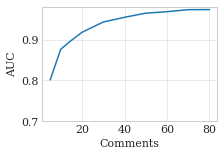

In [143]:

# style.use('seaborn-white')

fig = plt.figure(figsize=(HALF_COL_WIDTH, 2.3))
plt_x = REDDIT_SIZES
plt_y = reddit_aucs
plt.plot(plt_x, plt_y, '-')

plt.xlabel('Comments')
plt.ylabel('AUC')
plt.grid(True, alpha=0.5)
plt.ylim(0.7, 0.98)
plt.tight_layout()

plt.show()
fig.savefig(FIGURES_PATH +  'plt_reddit_doc_size_vs_auc.pdf', bbox_inches='tight')

Multi-doc Scatter Plots
===

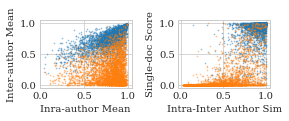

In [113]:
# Reddit
with open('temp_data/reddit/combined_results/results_40_full_data.p', 'rb') as f:
    (
        inter_probs_mean,
        intraA_probs_mean,
        intraB_probs_mean,
        inter_probs_std,
        intraA_probs_std,
        intraB_probs_std,
        labels,
        pred_lengths,
        probs_nc
    ) = pickle.load(f)
    

inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
labels = np.array(labels)
pred_lengths = np.array(pred_lengths)


probs_nc = np.array(probs_nc)

n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)


intra_inter_diff = (1 - np.abs(inter_probs_mean - intra_probs_mean))

mask = np.random.rand(len(labels)) < 0.075


fig, axs = plt.subplots(1, 2, figsize=(4, 1.6))
# axs[0].scatter(inter_probs_std[np.logical_and(mask, labels==True)], inter_probs_mean[np.logical_and(mask, labels==True)], s=0.5, alpha=0.4)
# axs[0].scatter(inter_probs_std[np.logical_and(mask, labels==False)], inter_probs_mean[np.logical_and(mask, labels==False)], s=0.5, alpha=0.4)
# axs[0].set_xlabel('Inter-author Std. dev')
# axs[0].set_ylabel('Inter-author Mean')



axs[0].scatter(intra_probs_mean[np.logical_and(mask, labels==True)], inter_probs_mean[np.logical_and(mask, labels==True)], s=0.5, alpha=0.4)
axs[0].scatter(intra_probs_mean[np.logical_and(mask, labels==False)], inter_probs_mean[np.logical_and(mask, labels==False)], s=0.5, alpha=0.4)
axs[0].set_xlabel('Inra-author Mean')
axs[0].set_ylabel('Inter-author Mean')
# axs[1].legend(labels=['Same Author', 'Different Author'], loc='best', markerscale=4.)

axs[1].scatter(intra_inter_diff[np.logical_and(mask, labels==True)], probs_nc[np.logical_and(mask, labels==True)], s=0.5, alpha=0.4)
axs[1].scatter(intra_inter_diff[np.logical_and(mask, labels==False)], probs_nc[np.logical_and(mask, labels==False)], s=0.5, alpha=0.4)
axs[1].set_xlabel('Intra-Inter Author Sim')
axs[1].set_ylabel('Single-doc Score')


plt.tight_layout()
fig.show()
# plt.savefig(FIGURES_PATH + 'plt_reddit_multi_doc_probs_small.pdf', format='pdf')
# tikzplotlib.save(FIGURES_PATH + 'plt_reddit_multi_doc_probs.pgf')

In [115]:
intra_probs_mean.mean()

0.79286394110126

In [110]:
with open('temp_data/pan/combined_results/results_15.p', 'rb') as f:
    (
        inter_probs_mean,
        intraA_probs_mean,
        intraB_probs_mean,
        inter_probs_std,
        intraA_probs_std,
        intraB_probs_std,
        labels,
        pred_lengths,
        probs_nc
    ) = pickle.load(f)

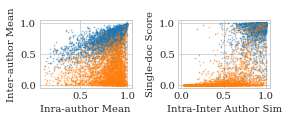

In [116]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
labels = np.array(labels)
pred_lengths = np.array(pred_lengths)


probs_nc = np.array(probs_nc)

n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)


intra_inter_diff = (1 - np.abs(inter_probs_mean - intra_probs_mean))

mask = np.random.rand(len(labels)) < 0.075


fig, axs = plt.subplots(1, 2, figsize=(4, 1.6))
# axs[0].scatter(inter_probs_std[np.logical_and(mask, labels==True)], inter_probs_mean[np.logical_and(mask, labels==True)], s=0.5, alpha=0.4)
# axs[0].scatter(inter_probs_std[np.logical_and(mask, labels==False)], inter_probs_mean[np.logical_and(mask, labels==False)], s=0.5, alpha=0.4)
# axs[0].set_xlabel('Inter-author Std. dev')
# axs[0].set_ylabel('Inter-author Mean')



axs[0].scatter(intra_probs_mean[np.logical_and(mask, labels==True)], inter_probs_mean[np.logical_and(mask, labels==True)], s=0.5, alpha=0.4)
axs[0].scatter(intra_probs_mean[np.logical_and(mask, labels==False)], inter_probs_mean[np.logical_and(mask, labels==False)], s=0.5, alpha=0.4)
axs[0].set_xlabel('Inra-author Mean')
axs[0].set_ylabel('Inter-author Mean')
# axs[1].legend(labels=['Same Author', 'Different Author'], loc='best', markerscale=4.)

axs[1].scatter(intra_inter_diff[np.logical_and(mask, labels==True)], probs_nc[np.logical_and(mask, labels==True)], s=0.5, alpha=0.4)
axs[1].scatter(intra_inter_diff[np.logical_and(mask, labels==False)], probs_nc[np.logical_and(mask, labels==False)], s=0.5, alpha=0.4)
axs[1].set_xlabel('Intra-Inter Author Sim')
axs[1].set_ylabel('Single-doc Score')


plt.tight_layout()
fig.show()
# plt.savefig(FIGURES_PATH + 'plt_pan_multi_doc_probs_small.pdf', format='pdf')
# tikzplotlib.save(FIGURES_PATH + 'plt_reddit_multi_doc_probs.pgf')

In [117]:
intra_probs_mean.mean()

0.79286394110126

In [87]:
with open('temp_data/reddit/multidoc_10_limitted_data_40_capped/experiment_data10.p', 'rb') as f:
    (
        author_bounds, 
        author_bounds_test, 
        author_subreddit, 
        author_subreddit_test, 
        x_shape, 
        x_shape_test,
        exclude_users,
        exclude_users_test,
        X_idxs_train,
        Y_train,
        X_idxs_test,
        Y_test
    ) = pickle.load(f)

In [79]:
from collections import defaultdict
import re

In [88]:
author_mapping = defaultdict(set)
author_to_root = {}
for y in author_bounds.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping[u].add(y)
    author_to_root[y] = u
    
author_mapping_test = defaultdict(set)
author_to_root_test = {}
for y in author_bounds_test.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping_test[u].add(y)
    author_to_root_test[y] = u

In [89]:
len(author_mapping) + len(author_mapping_test)

27789

In [97]:
27789/46465

0.5980630582158614